In [2]:
from cProfile import label
from os import times
from tokenize import cookie_re
from xmlrpc.client import boolean
from numpy.core.shape_base import atleast_2d
from numpy.lib import type_check
from scipy import fftpack
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal

HPC_OR_LOCAL = "LOCAL"
# "HPC" -> no graph
# "LOCAL" -> graph

# detects the first downward zerocross point


def getDownwardZeroCrossIndex(vector1d):
    downCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            downCount=downCount + 1
        else:
            downCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] < 0 and vector1d[searchIndex-1] > 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] < vector1d[searchIndex-5+i+1]:
                    downCount = 0
                else:
                    downCount = downCount+1
            if downCount == 10:
                # print(searchIndex)
                return searchIndex

# detects the first upward zerocross point


def getUpwardZeroCrossIndex(vector1d):
    upCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
            if upCount == 10:
                # print(searchIndex)
                return searchIndex


def getUpwardZeroCrossIndexFromArbitraryPoint(vector1d, startIndex):
    upCount = 0
    searchIndex = startIndex
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
                if upCount == 10:
                    # print(searchIndex)
                    return searchIndex


# Reads the csv file where time series data of detector coorinate is saved.
def loadCsvOutput(csvData):
    ndarrayData = np.loadtxt(csvData, delimiter=",")

    # Several timesteps are recorded twice in the raw csv file.
    # Below is the script which deletes the double-recorded timesteps.
    timeAtTheRowAbove = -100
    delRows = []
    for i in range(len(ndarrayData)):
        if timeAtTheRowAbove == ndarrayData[i, 0]:
            delRows.append(i)
        timeAtTheRowAbove = ndarrayData[i, 0]
    ndarrayData = np.delete(ndarrayData, delRows, 0)

    return ndarrayData

# Withdraws the time series of the detector's x coorinate


def getDetector(array):
    return array[:, 2]

# Withdraws the time series of the source's x coorinate


def getSource(array):
    return array[:, 1]

# trims the wave within the specified range


def trim(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    return trimmedArray

# trims the wave within the specified range and then offsets the wave so that the normal position can be x=0.


def trimAndOffset(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    offsettedArray = trimmedArray - vector1d[0]
    return offsettedArray

# performs fft. output[0] = power, output[1] = freq. both output are recognized as complex.


def fftWithWindow(FFTData, hannORhamming: str):
    dataPoints = len(FFTData)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    # print("acf")
    # print(acf)
    waveToTransform = acf*windowFunction*FFTData
    if HPC_OR_LOCAL == "LOCAL":
        plt.plot(waveToTransform)
        plt.show()
    FFT_power = np.fft.fft(waveToTransform, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(dataPoints, d=timeStep*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# under development


def window(data, hannORhamming: str):
    dataPoints = len(data)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    waveToTransform = acf*windowFunction*data
    return waveToTransform


def FFTonly(data):
    FFT_power = np.fft.fft(data, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(len(data), d=timeStep*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# calculates beta.


def getBetaSHG(Amp1, Amp2, Lambda, DeltaX):
    beta = 8*Amp2*Lambda*Lambda/DeltaX/Amp1/Amp1/np.pi/np.pi/2/2
    return beta

# attaches zeros to the raw wave data.


def zeroPadding(data):
    zeros = np.zeros(len(data))
    buffer = 0
    for i in range(50):
        if len(data) < 2**i:
            buffer = 2**(i+4) - len(data)
            break
    zeros = np.zeros(int(buffer/2))
    paddedData = np.hstack((zeros, data, zeros))
    acf = (sum(np.abs(data)) / len(data)) / \
        (sum(np.abs(paddedData)) / len(paddedData))
    return acf*paddedData

# searches the 1d array data for the input value,
# and returns the index of the array where the nearest value of the input value is contained.


def getIndexOfNearestValue(data, value):
    index = np.argmin(np.abs(np.array(data) - value))
    return index

# searches the FFT-performed 1d array of frequencies, and returns the index of 1st - 6th harmonics.


def getIndexUpToSixthHarmonic(data, frequency):
    index1 = getIndexOfNearestValue(data, frequency)
    index2 = getIndexOfNearestValue(data, frequency*2)
    index3 = getIndexOfNearestValue(data, frequency*3)
    index4 = getIndexOfNearestValue(data, frequency*4)
    index5 = getIndexOfNearestValue(data, frequency*5)
    index6 = getIndexOfNearestValue(data, frequency*6)
    return np.array([index1, index2, index3, index4, index5, index6], dtype=np.int64)


def getBetaFreqMix(aSum, aDif, aF1, aF2, freq1, freq2, DeltaX, vel):
    aMix = (aSum+aDif)/2
    Lambda1 = vel/freq1
    Lambda2 = vel/freq2
    K1 = 2*math.pi/Lambda1
    K2 = 2*math.pi/Lambda2
    return np.array([4*aDif/DeltaX/aF1/aF2/K1/K2, 4*aSum/DeltaX/aF1/aF2/K1/K2, 4*aMix/DeltaX/aF1/aF2/K1/K2])


9.994545760196831e-12
9.986807445997127e-12
9.973921123552873e-12
9.955905239256637e-12
9.932792264909237e-12
9.904621706237294e-12
9.871438588945192e-12
9.833297466367468e-12
9.790264121511585e-12
9.742415424789996e-12
9.689839530811533e-12
x_detec1


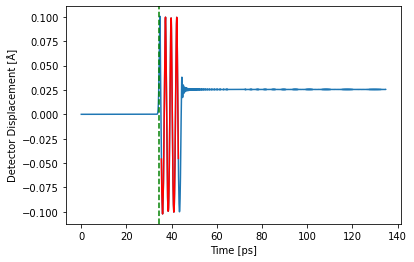

timeStep Δt is:
0.001
trimmed and offseted form of superimposed wave


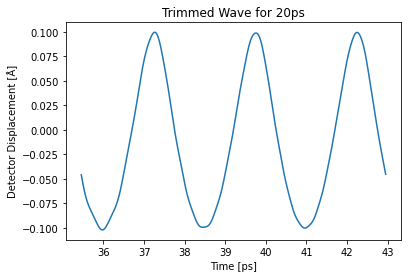

Windowed Wave


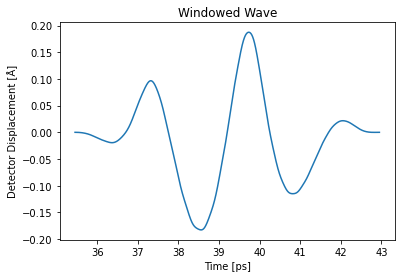

padded wave


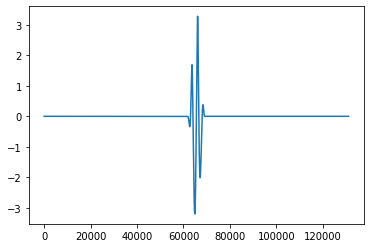


timeStep Δt is:
0.001
wave velocity v[m/s] is:
5509.9794815121195
wave length λ1 is:
1.37749487037803e-08


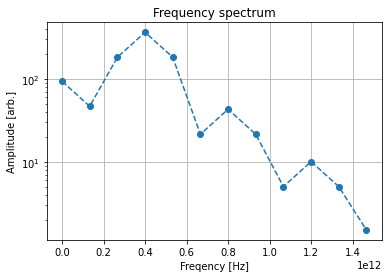

9.689839530811533e-12 4.8460529961584925e-12 5.737330781528116e-13 4.8460529961584925e-12
beta(SHG):
2.3404790464703566
beta(FreqMix): f1-f2, f1+f2, ave 
[9.8874479  1.17059304 5.52902047]


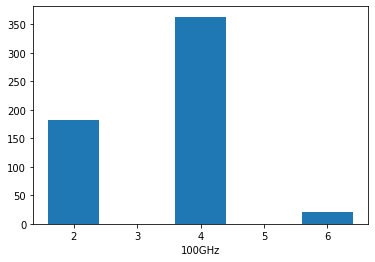

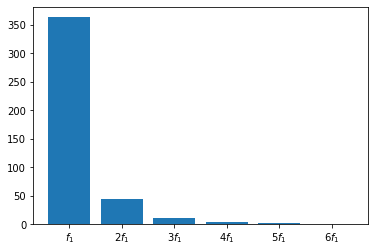

9.632634999589577e-12
9.570915661844571e-12
9.504808027314214e-12
9.434446094762185e-12
9.359976780247252e-12
9.281565260297322e-12
9.19939994170814e-12
9.113784231977767e-12
9.024581833824273e-12
8.932553723523074e-12
8.83751564408949e-12
8.739792557955725e-12
8.639608698449858e-12
8.537194383598858e-12
8.432829298865616e-12
8.326846234289773e-12
8.219592989676338e-12
8.111378403692178e-12
8.002459275406598e-12


In [17]:
freqs_f1 = range(400, 500, 100)

freqIndex = 0

detecMin = 2
detecMax = 31
detecs = (range(detecMin, detecMax+1))

af1s = np.zeros((len(freqs_f1), len(detecs)))
af2s = np.zeros((len(freqs_f1), len(detecs)))
a2f1s = np.zeros((len(freqs_f1), len(detecs)))
asums = np.zeros((len(freqs_f1), len(detecs)))
adiffs = np.zeros((len(freqs_f1), len(detecs)))

detecsAtT0 = loadCsvOutput(
    "outp.csv")[0, 1:31]-loadCsvOutput("outp.csv")[0, 1]

betaSHGArray = np.zeros((len(freqs_f1), len(detecs)))
betaSHGArrayCorrected = np.zeros((len(freqs_f1), len(detecs)))

waveLength1Array = np.zeros(len(freqs_f1))
waveVelocityArray = np.zeros((len(freqs_f1),len(detecs)))

for freq in freqs_f1:
    data1 = loadCsvOutput("outp.csv")
    data = data1
    # print(data)

    HPC_OR_LOCAL = "HPC"

    timeStep = data1[1, 0] - data1[0, 0]
    time = data[:, 0]
    x_source = data[:, 1]
    TLCM = 10
    T1 = 1000/freq #ps
    T2 = 5
    inputFreq1 = 10**12 / T1  # [Hz] #500
    inputFreq2 = 10**12/T2  # 200
    # wave amplitude at the source
    source_amp = 0.1  # [Å]

    Nc = 3

    # Ns: Number of data points in one cycle
    Ns = T1/timeStep

    detecInterval = detecsAtT0[3]-detecsAtT0[2]

    for detecNum in detecs:
        detecIndex = 0
        #detecNum = i
        x_detec = data[:, detecNum]
        u_detec = x_detec - x_detec[0]
        # N: Total Number of data points in thw windowed region
        N = int(Nc*Ns)
        # plt.plot(data[:,1]-data[0,1])
        # plt.plot(u_detec)
        # plt.show()

        # ゼロクロス法の音速測定が人力なのよなあ・・・
        # data[:,2],すなわちsourceのすぐ隣のdetectorのゼロクロスポイントが11551．
        # x=vtかつ隣接detectorの距離は85.667Å程度だから，
        # 8.5667nm = 5500pm/ps *t
        # 8.5667*10^-9m = 5500*10^-12m/ps *t
        # t/ps=8.5667*10^3/5500
        deltaTDetec = detecInterval*10**2/5500  # ps
        zeroCrossTimeStep = getUpwardZeroCrossIndexFromArbitraryPoint(
            u_detec, int(T1*3/4/timeStep+deltaTDetec*(detecNum-1)/timeStep))
        # print(zeroCrossTimeStep)
        # plt.plot(u_detec)
        # plt.axvline(x=zeroCrossTimeStep,color="red")
        # plt.show()

        arrivalTimeStep = int(zeroCrossTimeStep - T1/timeStep)
        # print(arrivalTimeStep)

        windowStartTimeStep = int(arrivalTimeStep + T1/timeStep/2)
        delta_x = x_detec[0] - x_source[0]

        waveVelocity = delta_x*(10**(-10)) / \
            ((arrivalTimeStep * timeStep)*(10**(-12)))
        waveVelocityArray[freqIndex][detecIndex]=waveVelocity
        waveLength1 = waveVelocity * T1 * (10**(-12))
        if detecNum == detecs[0]:
            waveLength1Array[freqIndex]=waveLength1
        
        waveLength2 = waveVelocity * T2 * (10**(-12))

        trimmedWave = trimAndOffset(x_detec, windowStartTimeStep, N)
        #plt.plot(trimmedWave)
        trimmedTime = trim(time, windowStartTimeStep, N)
        windowedWave = window(trimmedWave, "hann")
        paddedWave = zeroPadding(windowedWave)
        paddedWaveWithoutWindow = zeroPadding(trimmedWave)

        ##SUPER IMPORTANT##
        waveToTransform = windowedWave
        ##CHOU DAIJI##

        # FFT. transformedArray: [0]=power, [1]=freq
        # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
        #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
        FFTedData = FFTonly(waveToTransform)
        #FFTedData=FFTonly(window(trimmedWave, "hann"))
        absFFTData = np.abs(FFTedData)

        # higher harmonics amplitude[arb]
        harmonicsIndex = getIndexUpToSixthHarmonic(absFFTData[1], inputFreq1)
        A1 = absFFTData[0][harmonicsIndex[0]]
        A2 = absFFTData[0][harmonicsIndex[1]]
        A3 = absFFTData[0][harmonicsIndex[2]]
        A4 = absFFTData[0][harmonicsIndex[3]]
        A5 = absFFTData[0][harmonicsIndex[4]]
        A6 = absFFTData[0][harmonicsIndex[5]]
        Af1 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq1)]
        Af2 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq2)]
        Afsum = absFFTData[0][getIndexOfNearestValue(
            absFFTData[1], inputFreq1+inputFreq2)]
        Afdif = absFFTData[0][getIndexOfNearestValue(
            absFFTData[1], inputFreq1-inputFreq2)]

        af1_0 = source_amp*10**-10
        af2_0 = source_amp*10**-10

        af1 = Af1*2/int(len(waveToTransform))*10**-10
        print(af1)
        af1s[freqIndex, detecNum-detecMin] = af1

        af2 = Af2*2/int(len(waveToTransform))*10**-10
        af2s[freqIndex, detecNum-detecMin] = af2
        asum = Afsum*2/int(len(waveToTransform))*10**-10
        asums[freqIndex, detecNum-detecMin] = asum
        adif = Afdif*2/int(len(waveToTransform))*10**-10
        adiffs[freqIndex, detecNum-detecMin] = adif

        a2f1 = A2*2/int(len(waveToTransform))*10**-10
        a2f1s[freqIndex, detecNum-detecMin] = a2f1

        a1s = source_amp*10**-10
        a2 = 2*A2/int(len(waveToTransform))*10**-10

        betaSHG = getBetaSHG(a1s, a2f1, waveLength1, delta_x*(10**-10))
        betaSHGCorrected = getBetaSHG(
            af1, a2f1, waveLength1, delta_x*(10**-10))
        """with open("betaSHG.txt", "w") as f:
            f.write(str(betaSHG))
        """
        betaSHGArray[freqIndex, detecNum-detecMin] = betaSHG
        betaSHGArrayCorrected[freqIndex, detecNum-detecMin] = betaSHGCorrected

        betaFreqMix = getBetaFreqMix(
            asum, adif, af1_0, af2_0, inputFreq1, inputFreq2, delta_x*10**-10, waveVelocity)
        """with open("betaFreqMix.txt", "w") as f:
            f.write(str(betaFreqMix))
        """
        detecIndex = detecIndex+1
        # drawings
        #if True:
        if detecNum-detecMin==10 and freq==400:
        #if HPC_OR_LOCAL == "LOCAL" and detecNum-detecMin == 10 :
            fig = plt.figure()
            print("x_detec1")
            y = u_detec
            time_red = time[windowStartTimeStep:windowStartTimeStep+N]
            y_red = y[windowStartTimeStep:windowStartTimeStep+N]
            time1 = time[:windowStartTimeStep]
            y1 = y[:windowStartTimeStep]
            time2 = time[windowStartTimeStep+N:]
            y2 = y[windowStartTimeStep+N:]
            plt.xlabel("Time [ps]")
            plt.ylabel("Detector Displacement [Å]")
            plt.plot(time, y)
            plt.plot(time_red, y_red, color="red")
            plt.axvline(x=arrivalTimeStep*timeStep,
                        color="green", linestyle="--")
            #plt.axvline(x=windowStartTimeStep*timeStep, color="red")
            #plt.axvline(x=(windowStartTimeStep+N)*timeStep, color="red")
            plt.show()

            print("timeStep Δt is:")
            print(timeStep)

            print("trimmed and offseted form of superimposed wave")
            plt.title("Trimmed Wave for 20ps")
            plt.plot(trimmedTime, trimmedWave)
            plt.xlabel("Time [ps]")
            plt.ylabel("Detector Displacement [Å]")
            plt.show()

            print("Windowed Wave")
            plt.plot(trimmedTime, windowedWave)
            plt.title("Windowed Wave")
            plt.xlabel("Time [ps]")
            plt.ylabel("Detector Displacement [Å]")
            plt.show()

            print("padded wave")
            plt.plot(paddedWave)
            plt.show()

            print()
            print("timeStep Δt is:")
            print(timeStep)

            print("wave velocity v[m/s] is:")
            print(waveVelocity)

            print("wave length λ1 is:")
            print(waveLength1)

            fig, ax = plt.subplots()
            ax.set_yscale("log")
            #ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
            ax.plot(absFFTData[1, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4],
                    absFFTData[0, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4], marker="o", linestyle="--")
            ax.set_xlabel("Freqency [Hz]")
            ax.set_ylabel("Amplitude [arb.]")
            ax.grid()
            plt.title("Frequency spectrum")
            plt.show()

            print(af1, af2, asum, adif)

            print("beta(SHG):")
            print(betaSHG)
            betaSHGArray[freqIndex, detecNum] = betaSHG
            print("beta(FreqMix): f1-f2, f1+f2, ave ")
            print(betaFreqMix)

            x_bar = np.array([inputFreq2, inputFreq1-inputFreq2,
                              inputFreq1, inputFreq1+inputFreq2, inputFreq2*2])
            y_bar = np.array([Af2, Afdif, Af1, Afsum, A2])
            x_bar = x_bar / 10**11
            plt.xlabel("100GHz")
            # print(x_bar)
            # print(y_bar)
            plt.bar(x_bar, y_bar)
            plt.show()

            x_bar = np.array(["$f_1$", "$2f_1$", "3$f_1$",
                              "4$f_1$", "5$f_1$", "6$f_1$"])
            y_bar = np.array([A1, A2, A3, A4, A5, A6])
            # print(x_bar)
            # print(y_bar)
            plt.bar(x_bar, y_bar)
            plt.show()
    #print(af1s[freqIndex])
    #print(a2f1s[freqIndex])
    np.savetxt(str(freq)+"GHzDamp.txt", af1s[freqIndex])
    freqIndex += 1


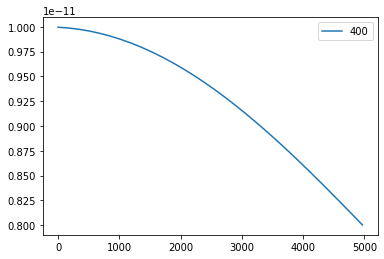

In [18]:


for i in range(af1s.shape[0]):
    plt.plot(detecsAtT0, af1s[i])
plt.legend(freqs_f1)
plt.show()


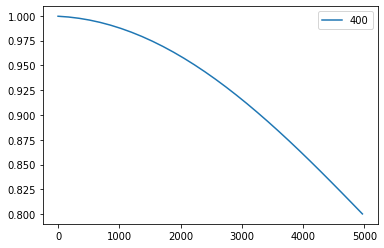

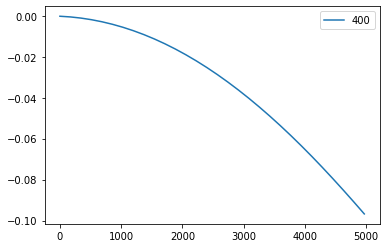

In [19]:
af1Ratios = af1s/(10**-11)
f1dBs = np.log10(af1Ratios)
for i in range(len(af1Ratios)):
    plt.plot(detecsAtT0, af1Ratios[i])
plt.legend(freqs_f1)
plt.show()
for i in range(len(f1dBs)):
    plt.plot(detecsAtT0, f1dBs[i])
plt.legend(freqs_f1)
plt.show()


↑減衰が指数関数じゃない！！ぴえん

In [20]:
plt.plot(detecsAtT0,af1s[3])

plt.show()
print(np.corrcoef(detecsAtT0,af1s[3]))


target = np.log10(a2f1s[3]/detecsAtT0)
plt.plot(detecsAtT0,target)
plt.show()
print(np.corrcoef(detecsAtT0,a2f1s[3]))


plt.plot(detecsAtT0, betaSHGArray[3])
plt.plot(detecsAtT0, betaSHGArrayCorrected[3], marker="o")
plt.show()
print(np.corrcoef(detecsAtT0,betaSHGArray[3]))
print(np.corrcoef(detecsAtT0,betaSHGArrayCorrected[3]))


plt.plot(detecsAtT0,a2f1s[3]/(10**-22))
plt.plot(detecsAtT0,a2f1s[3]/af1s[3]/af1s[3])
plt.show()
print(np.corrcoef(detecsAtT0,a2f1s[3]/(10**-22)))
print(np.corrcoef(detecsAtT0,a2f1s[3]/af1s[3]/af1s[3]))




IndexError: index 3 is out of bounds for axis 0 with size 1

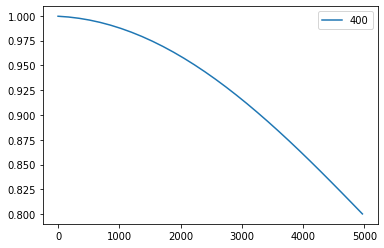

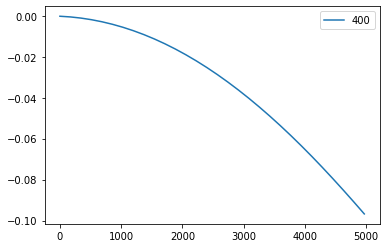

FileNotFoundError: ./200GHz/outp_1.csv not found.

In [21]:
af1sScaled = af1s
for i in range(len(af1Ratios)):
    plt.plot(detecsAtT0, af1Ratios[i])
plt.legend(freqs_f1)
plt.show()
for i in range(len(f1dBs)):
    plt.plot(detecsAtT0, f1dBs[i])
plt.legend(freqs_f1)
plt.show()

plt.plot(loadCsvOutput("./200GHz/outp_1.csv")[:,10])
plt.show()

In [22]:
hosei = af1s[2,-1]/af1s[3,-1]
plt.plot(detecsAtT0,af1s[2])
plt.plot(detecsAtT0,hosei*af1s[3])
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 1

0.4139025908750041


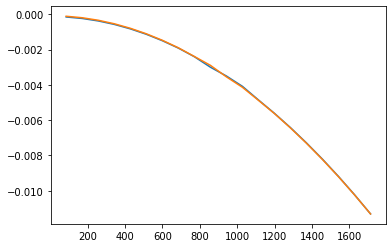

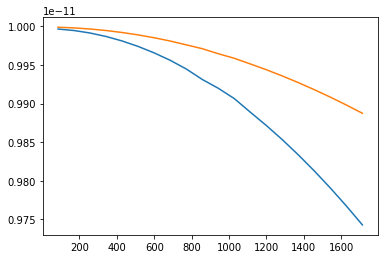

In [ ]:
hosei = f1dBs[2,-1]/f1dBs[3,-1]
print(hosei)
plt.plot(detecsAtT0,f1dBs[2])
plt.plot(detecsAtT0,hosei*f1dBs[3])
plt.show()

plt.plot(detecsAtT0,af1s[2])
plt.plot(detecsAtT0,np.exp(hosei*f1dBs[3])*10**-11)
plt.show()

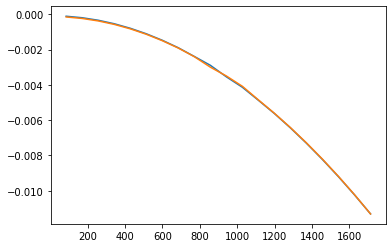

In [ ]:
hoseisArray = np.zeros([len(freqs_f1),len(freqs_f1)])
for i in range(len(freqs_f1)):
    hoseis = np.array([f1dBs[0,-1],f1dBs[1,-1],f1dBs[2,-1],f1dBs[3,-1]])/f1dBs[i,-1]
    hoseisArray[i]=hoseis

plt.plot(detecsAtT0,hoseisArray[3,2]*f1dBs[3])
plt.plot(detecsAtT0,f1dBs[2])
plt.show()


NameError: name 'hoseis' is not defined

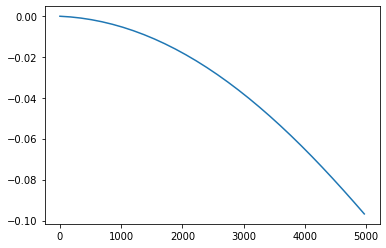

In [23]:
num = 0 #num = 0~2 1:300GHz, 2:400GHz, 3=500GHz
plt.plot(detecsAtT0,f1dBs[num])
plt.plot(detecsAtT0,hoseis[num]*f1dBs[3])
plt.show()

plt.plot(detecsAtT0,af1s[num])
plt.plot(detecsAtT0,np.exp(hoseis[num]*f1dBs[3])*10**-11)
plt.show()

In [24]:
A2f1sdB=np.log10(a2f1s/10**-11)
#plt.plot(A2f1sdB[3])
#plt.show()
plt.plot(10**(A2f1sdB[3]*hoseis[2])*10**-11)
plt.plot(10**A2f1sdB[3]*10**-11, marker="o")
plt.plot(a2f1s[3])
#plt.legend(["補正付き500GHz","補正なし500GHz","生データ"])
plt.show()
plt.plot(hoseis[2]*a2f1s[3])

plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 1

range(200, 600, 100)
1.0
0.6666666666666666
0.5
0.4


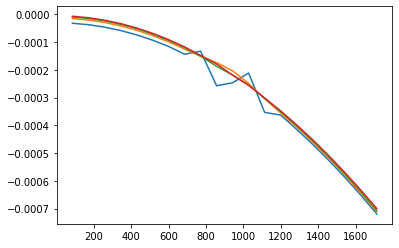

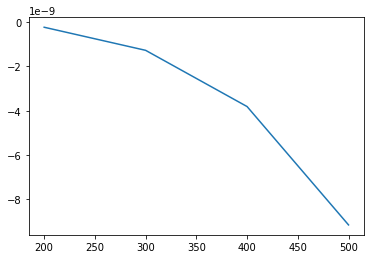

"\nfrom sklearn.linear_model import Ridge,LinearRegression\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nimport pandas as pd\n\nx=detecsAtT0\ny=f1dBs[3]\ndegree = 2\nmodel = make_pipeline(PolynomialFeatures(degree,include_bias=False),LinearRegression(fit_intercept=False))\nmodel.fit(x.reshape(-1,1),y)\ny_model=model.predict(x.reshape(-1,1))\ndf = pd.DataFrame({'y_model.predict':y_model,},index=x)\ndf.sort_index().plot(kind ='line',figsize=(10.,5.))\nmodel.steps[1][1].coef_\n"

In [ ]:
print(freqs_f1)
coeffs = np.zeros(len(f1dBs))
for i in range(len(f1dBs)):
    print(freqs_f1[0]/freqs_f1[i])
    plt.plot(detecsAtT0,f1dBs[i]*(freqs_f1[0]/freqs_f1[i])**4)
    coe=np.polyfit(detecsAtT0,f1dBs[i],2)[0]
    coeffs[i]=coe
plt.show()
plt.plot(freqs_f1,coeffs)
plt.show()



"""
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd

x=detecsAtT0
y=f1dBs[3]
degree = 2
model = make_pipeline(PolynomialFeatures(degree,include_bias=False),LinearRegression(fit_intercept=False))
model.fit(x.reshape(-1,1),y)
y_model=model.predict(x.reshape(-1,1))
df = pd.DataFrame({'y_model.predict':y_model,},index=x)
df.sort_index().plot(kind ='line',figsize=(10.,5.))
model.steps[1][1].coef_
"""


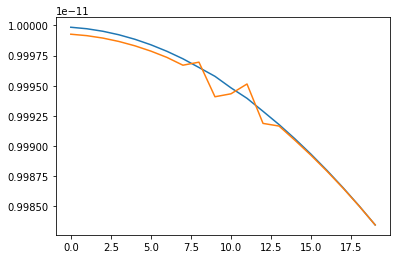

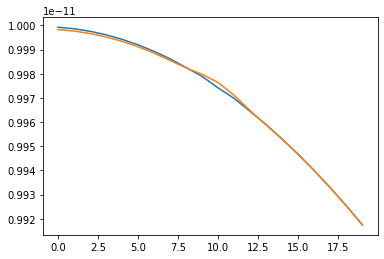

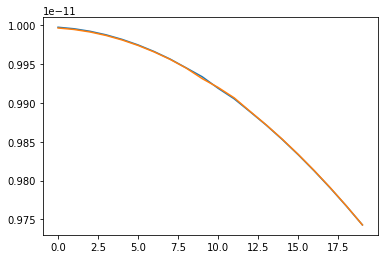

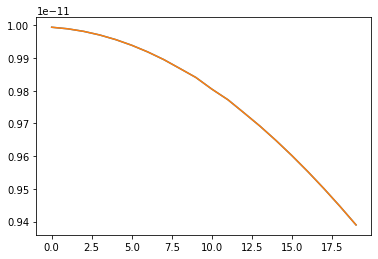

In [ ]:
for i in range(len(hoseis)):
    plt.plot(10**(f1dBs[3]*hoseis[i]+np.log10(source_amp*10**-10)))
    plt.plot(af1s[i])
    plt.show()

[[ 5.32880116e-10  5.99788882e-08 -1.12482568e-05 -3.32782024e-04
   1.84047384e-01]
 [ 1.06413666e-10  1.19775034e-08 -2.24622425e-06 -6.64550133e-05
   3.67534016e-02]
 [ 3.38732451e-11  3.81263913e-09 -7.15010651e-07 -2.11537394e-05
   1.16992208e-02]
 [ 1.40202239e-11  1.57806121e-09 -2.95944761e-07 -8.75558752e-06
   4.84233782e-03]]


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


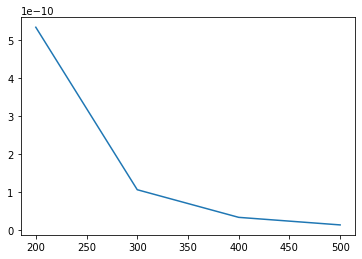

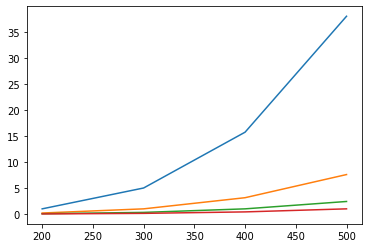

In [ ]:
degree = 4
coeffsArray = np.zeros([len(freqs_f1),degree+1])
for i in range(len(freqs_f1)):
    coeffsArray[i] = np.polyfit(freqs_f1,hoseisArray[i],degree)
print(coeffsArray)
plt.plot(freqs_f1,coeffsArray[:,0])
plt.show()

for i in range(len(freqs_f1)):
    plt.plot(freqs_f1, hoseisArray[i])
plt.show()

In [25]:
plt.plot(detecsAtT0, af1s[3])
plt.plot(detecsAtT0,a2f1s[3])
plt.show()
#plt.plot(detecsAtT0, a2f1s[3]/af1s[3,0]/af1s[3,0])
plt.plot(detecsAtT0, a2f1s[3]/af1s[3]/af1s[3], linestyle="none", marker="o")
plt.show()
#a2=beta*a1s**2*k**2*x/8
#a2/a1/a1=beta*k*k*x/8
#let slope = beta*k*k*/8 
#beta = slope*8/k/k
linearAmp=a2f1s[3]/af1s[3]/af1s[3]
coeffs = np.polyfit(detecsAtT0*10**-10,linearAmp,1)
slope=coeffs[0]
waveNumber=np.pi*2/waveLength1Array[3]
beta=slope*8/waveNumber/waveNumber
print(beta)


IndexError: index 3 is out of bounds for axis 0 with size 1

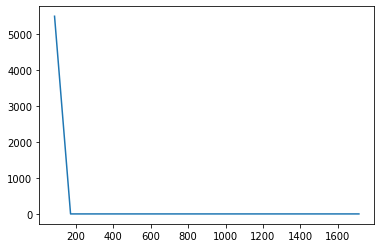

array([5506.49858586,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

In [ ]:
plt.plot(detecsAtT0,waveVelocityArray[3])
plt.show()
waveVelocityArray[3]